In [139]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, Flatten, Concatenate, Normalization
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import json

laps_df = pd.read_pickle('../data/preprocessed_laps.pkl')

laps_df.head()

,Driver,LapTime,SpeedAtFinishLine,IsPersonalBest,FreshTyre,Team,Humidity,Rainfall,Speed_min,RPM_max,...,Pressure_Category_Low,Pressure_Category_Normal,AirTemp_Category_Cold,AirTemp_Category_Normal,AirTemp_Category_Hot,AirTemp_Category_Very Hot,TrackTemp_Category_Cold,TrackTemp_Category_Normal,TrackTemp_Category_Hot,TrackTemp_Category_Very Hot
1,VER,0.527426,0.560000,True,False,Red Bull Racing,0.065574,False,0.436620,0.452991,...,False,True,False,False,True,False,False,True,False,False
3,VER,0.527460,0.560000,False,False,Red Bull Racing,0.065574,False,0.450704,0.372960,...,False,True,False,False,True,False,False,True,False,False
5,VER,0.527630,0.565714,False,False,Red Bull Racing,0.065574,False,0.408451,0.289044,...,False,True,False,False,True,False,False,True,False,False
6,VER,0.528226,0.565714,False,False,Red Bull Racing,0.065574,False,0.394366,0.528361,...,False,True,False,False,True,False,False,True,False,False
11,VER,0.537936,0.560000,False,False,Red Bull Racing,0.049180,False,0.422535,0.426573,...,False,True,False,False,True,False,False,True,False,False


In [140]:
categorical_features = ['Driver', 'Team']
numerical_features = laps_df.drop(columns=categorical_features + ['LapTime']).columns.tolist()

In [141]:
label_encoder_driver = LabelEncoder()
label_encoder_team = LabelEncoder()
laps_df['Driver_encoded'] = label_encoder_driver.fit_transform(laps_df['Driver'])
laps_df['Team_encoded'] = label_encoder_team.fit_transform(laps_df['Team'])

In [142]:
X_driver = laps_df['Driver_encoded'].values
X_team = laps_df['Team_encoded'].values
X_numerical = laps_df[numerical_features].values
y = laps_df['LapTime'].values

In [143]:
X_driver = X_driver.astype(np.int32)
X_team = X_team.astype(np.int32)
X_numerical = X_numerical.astype(np.float32)
y = y.astype(np.float32)
X_train_driver, X_test_driver, X_train_team, X_test_team, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_driver, X_team, X_numerical, y, test_size=0.2, random_state=42
)

In [144]:
input_driver = Input(shape=(1,), name='Driver_Input')
input_team = Input(shape=(1,), name='Team_Input')
input_numerical = Input(shape=(X_train_num.shape[1],), name='Numerical_Input')

In [145]:
embedding_driver = Embedding(input_dim=laps_df['Driver_encoded'].nunique(), output_dim=10)(input_driver)
embedding_team = Embedding(input_dim=laps_df['Team_encoded'].nunique(), output_dim=5)(input_team)

embedding_driver_flat = Flatten()(embedding_driver)
embedding_team_flat = Flatten()(embedding_team)

In [146]:
combined_features = Concatenate()([embedding_driver_flat, embedding_team_flat, input_numerical])


In [147]:
x = layers.Dense(128, activation='relu')(combined_features)
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1)(x)

In [148]:
model = models.Model(inputs=[input_driver, input_team, input_numerical], outputs=output)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

history = model.fit([X_train_driver, X_train_team, X_train_num], y_train, epochs=100, batch_size=32, validation_split=0.2)

test_loss, test_mae = model.evaluate([X_test_driver, X_test_team, X_test_num], y_test)

Epoch 1/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 0.0102 - mae: 0.0671 - val_loss: 0.0011 - val_mae: 0.0236
Epoch 2/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 9.1264e-04 - mae: 0.0218 - val_loss: 8.5877e-04 - val_mae: 0.0204
Epoch 3/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - loss: 5.9043e-04 - mae: 0.0179 - val_loss: 7.4000e-04 - val_mae: 0.0192
Epoch 4/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - loss: 5.1160e-04 - mae: 0.0170 - val_loss: 6.5578e-04 - val_mae: 0.0182
Epoch 5/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step - loss: 4.5868e-04 - mae: 0.0163 - val_loss: 0.0010 - val_mae: 0.0244
Epoch 6/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 4.6632e-04 - mae: 0.0165 - val_loss: 9.0988e-04 - val_mae: 0.0234
Epoch 7/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 4.0506e-04 - mae: 0.0153 - val_loss: 6.3239e-04 - val_mae: 0.0178
Epoch 8/100
264/264 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 3.5048e-04 - mae: 0.0142 - val_loss: 5.6924e-0

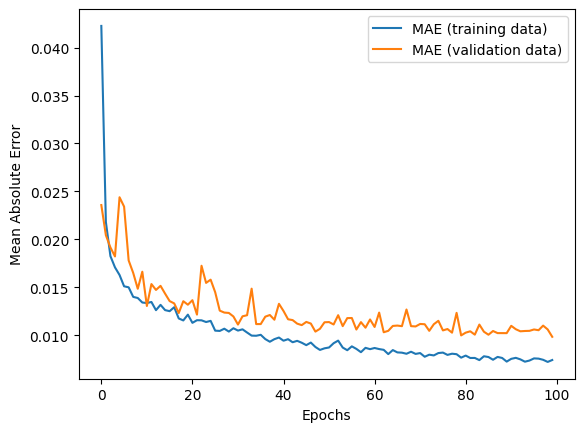

test_loss: 0.00026678002905100584
test_mae: 0.00935773178935051


In [149]:
plt.plot(history.history['mae'], label='MAE (training data)')
plt.plot(history.history['val_mae'], label='MAE (validation data)')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()
print(f"test_loss: {test_loss}")
print(f"test_mae: {test_mae}")

In [152]:
def predict(row):
    input_data = pd.DataFrame([row])
    input_data['Driver_encoded'] = label_encoder_driver.transform(input_data['Driver'])
    input_data['Team_encoded'] = label_encoder_team.transform(input_data['Team'])
    X_driver = input_data['Driver_encoded'].values.astype(np.int32)
    X_team = input_data['Team_encoded'].values.astype(np.int32)
    X_numerical = input_data.drop(columns=["Driver", "Team", "Driver_encoded", "Team_encoded"]).values.astype(np.float32)
    print(X_numerical.shape)
    prediction = model.predict([X_driver, X_team, X_numerical])
    return prediction[0][0]



In [153]:
with open('normalised_max_min.json') as json_file:
    normalised_max_min = json.load(json_file)

row = laps_df.drop(columns=['LapTime']).iloc[99]
predicted_lap_time = predict(row)
print((predicted_lap_time*(normalised_max_min['LapTime']['max']-normalised_max_min['LapTime']['min'])) + normalised_max_min['LapTime']['min'])
print((laps_df.iloc[99]['LapTime']*(normalised_max_min['LapTime']['max']-normalised_max_min['LapTime']['min'])) + normalised_max_min['LapTime']['min'])


(1, 36)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
98.07682469367981
98.361


In [154]:
model.save('lap-time-model.keras')
model.save('../services/consumer/models/lap-time-model.keras')

In [155]:
joblib.dump(label_encoder_driver, 'led.pkl')
joblib.dump(label_encoder_team, 'let.pkl')
joblib.dump(label_encoder_driver, '../services/consumer/models/led.pkl')
joblib.dump(label_encoder_team, '../services/consumer/models/let.pkl')

['../services/consumer/models/let.pkl']

In [157]:
a = ['VER', 0.56, 1, 0,
       'Red Bull Racing', 0.0655737704918033, False, 0.4366197183098592,
       0.45299145299145316, 0.6071919934621487, True, True, False, False, False, False, False,
       0.13098107071941528, 0.0, False, False, False, True, False, False,
       True, False, False, False, True, False, False, True, False, False,
       True, False, False]
dict_ = {}
for i,j in enumerate(a):
    dict_[laps_df.drop(columns=["LapTime"]).columns.tolist()[i]] = j
dict_

{'Driver': 'VER',
 'SpeedAtFinishLine': 0.56,
 'IsPersonalBest': 1,
 'FreshTyre': 0,
 'Team': 'Red Bull Racing',
 'Humidity': 0.0655737704918033,
 'Rainfall': False,
 'Speed_min': 0.4366197183098592,
 'RPM_max': 0.45299145299145316,
 'RPM_std': 0.6071919934621487,
 'ContainsTrackStatus1': True,
 'ContainsTrackStatus2': True,
 'ContainsTrackStatus4': False,
 'ContainsTrackStatus6': False,
 'ContainsTrackStatus7': False,
 'SpeedAfterSector1IsFast': False,
 'SpeedAfterSector2IsFast': False,
 'combo_speed_max_speed_std': 0.13098107071941528,
 'combo_stint_lap_number': 0.0,
 'Compound_HARD': False,
 'Compound_INTERMEDIATE': False,
 'Compound_MEDIUM': False,
 'Compound_SOFT': True,
 'DirectionOfWind_East': False,
 'DirectionOfWind_North': False,
 'DirectionOfWind_South': True,
 'DirectionOfWind_West': False,
 'Pressure_Category_Very Low': False,
 'Pressure_Category_Low': False,
 'Pressure_Category_Normal': True,
 'AirTemp_Category_Cold': False,
 'AirTemp_Category_Normal': False,
 'AirTemp_Ca

In [158]:
predict(pd.DataFrame(dict_, index=[0]).iloc[0])

(1, 36)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


0.5243851

In [92]:
numerical_features

['SpeedAfterSector1',
 'SpeedAfterSector2',
 'SpeedAtFinishLine',
 'IsPersonalBest',
 'FreshTyre',
 'Humidity',
 'Rainfall',
 'Speed_min',
 'RPM_max',
 'RPM_std',
 'ContainsTrackStatus1',
 'ContainsTrackStatus2',
 'ContainsTrackStatus4',
 'ContainsTrackStatus6',
 'ContainsTrackStatus7',
 'SpeedAfterSector1IsFast',
 'SpeedAfterSector2IsFast',
 'combo_speed_max_speed_std',
 'combo_stint_lap_number',
 'Compound_HARD',
 'Compound_INTERMEDIATE',
 'Compound_MEDIUM',
 'Compound_SOFT',
 'DirectionOfWind_East',
 'DirectionOfWind_North',
 'DirectionOfWind_South',
 'DirectionOfWind_West',
 'Pressure_Category_Very Low',
 'Pressure_Category_Low',
 'Pressure_Category_Normal',
 'AirTemp_Category_Cold',
 'AirTemp_Category_Normal',
 'AirTemp_Category_Hot',
 'AirTemp_Category_Very Hot',
 'TrackTemp_Category_Cold',
 'TrackTemp_Category_Normal',
 'TrackTemp_Category_Hot',
 'TrackTemp_Category_Very Hot']

In [86]:
pd.DataFrame(dict_, index=[0]).reset_index(drop=True)

,Driver,SpeedAfterSector1,SpeedAfterSector2,SpeedAtFinishLine,IsPersonalBest,FreshTyre,Team,Humidity,Rainfall,Speed_min,...,AirTemp_Category_Cold,AirTemp_Category_Normal,AirTemp_Category_Hot,AirTemp_Category_Very Hot,TrackTemp_Category_Cold,TrackTemp_Category_Normal,TrackTemp_Category_Hot,TrackTemp_Category_Very Hot,Driver_encoded,Team_encoded
0,VER,0.477551,0.553648,0.56,1,0,Red Bull Racing,0.065574,0,0.43662,...,False,False,True,False,False,True,False,False,20,8


In [72]:
laps_df.drop(columns=["LapTime"]).columns.tolist()[0]

'Driver'